## Classify images with quantum machine learning

In [3]:
# General imports
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from pylab import cm
import warnings

warnings.filterwarnings("ignore")

# scikit-learn imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Qiskit imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

## QSVM for binary classification of MNIST

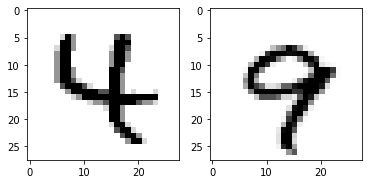

In [4]:
# Load MNIST dataset
DATA_PATH = 'quantum-challenge/2021-fall/challenge-3/resources/ch3_part1.npz'
data = np.load(DATA_PATH)

sample_train = data['sample_train']
labels_train = data['labels_train']
sample_test = data['sample_test']

# Split train data
sample_train, sample_val, labels_train, labels_val = train_test_split(
    sample_train, labels_train, test_size=0.2, random_state=42)

# Visualize samples
fig = plt.figure()

LABELS = [4, 9]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(1, num_labels, i+1)
    img = sample_train[labels_train==LABELS[i]][0].reshape((28, 28))
    ax.imshow(img, cmap="Greys")

In [14]:
# Standardize
ss = StandardScaler()
sample_train = ss.fit_transform(sample_train)
sample_val = ss.transform(sample_val)
sample_test = ss.transform(sample_test)

# Reduce dimensions
N_DIM = 5
pca = PCA(n_components=N_DIM)
sample_train = pca.fit_transform(sample_train)
sample_val = pca.transform(sample_val)
sample_test = pca.transform(sample_test)

# Normalize
mms = MinMaxScaler((-1, 1))
sample_train = mms.fit_transform(sample_train)
sample_val = mms.transform(sample_val)
sample_test = mms.transform(sample_test)

### Data Encoding
We will take the classical data and encode it to the quantum state space using a quantum feature map.
###    Quantum Feature Maps
- [**`PauliFeatureMap`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliFeatureMap.html)
- [**`ZZFeatureMap`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZFeatureMap.html)
- [**`ZFeatureMap`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html)


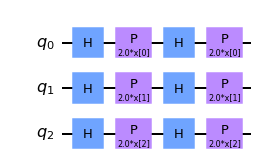

In [5]:
map_z = ZFeatureMap(feature_dimension=3, reps=2)
map_z.decompose().draw('mpl')

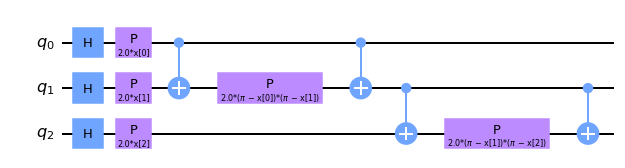

In [6]:
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='linear')
map_zz.decompose().draw('mpl')

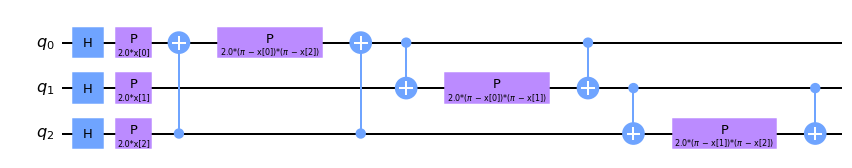

In [7]:
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='circular')
map_zz.decompose().draw('mpl')

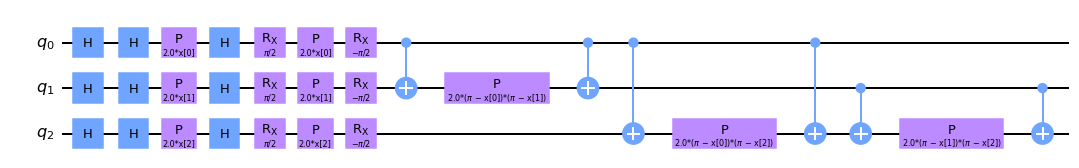

In [8]:
map_pauli = PauliFeatureMap(feature_dimension=3, reps=1, paulis = ['X', 'Y', 'ZZ'])
map_pauli.decompose().draw('mpl')

The [`NLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.NLocal.html) and [`TwoLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) functions in Qiskit's circuit library can also be used to create parameterised quantum circuits as feature maps. 


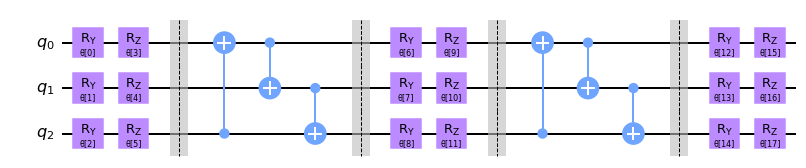

In [9]:
twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rz'], 
               entanglement_blocks='cx', entanglement='circular', insert_barriers=True)
twolocal.decompose().draw('mpl')

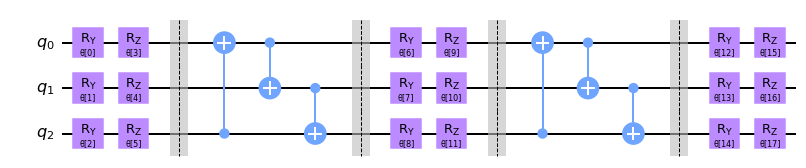

In [10]:
twolocaln = NLocal(num_qubits=3, reps=2,
               rotation_blocks=[RYGate(Parameter('a')), RZGate(Parameter('a'))], 
               entanglement_blocks=CXGate(), 
               entanglement='circular', insert_barriers=True)
twolocaln.decompose().draw('mpl')

Let's encode the first training sample using the `PauliFeatureMap`:

In [11]:
print(f'First training data: {sample_train[0]}')

First training data: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   4  89 130 158 254 221 130  30   2   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2  28
 211 253 253 251 241 244 253 2

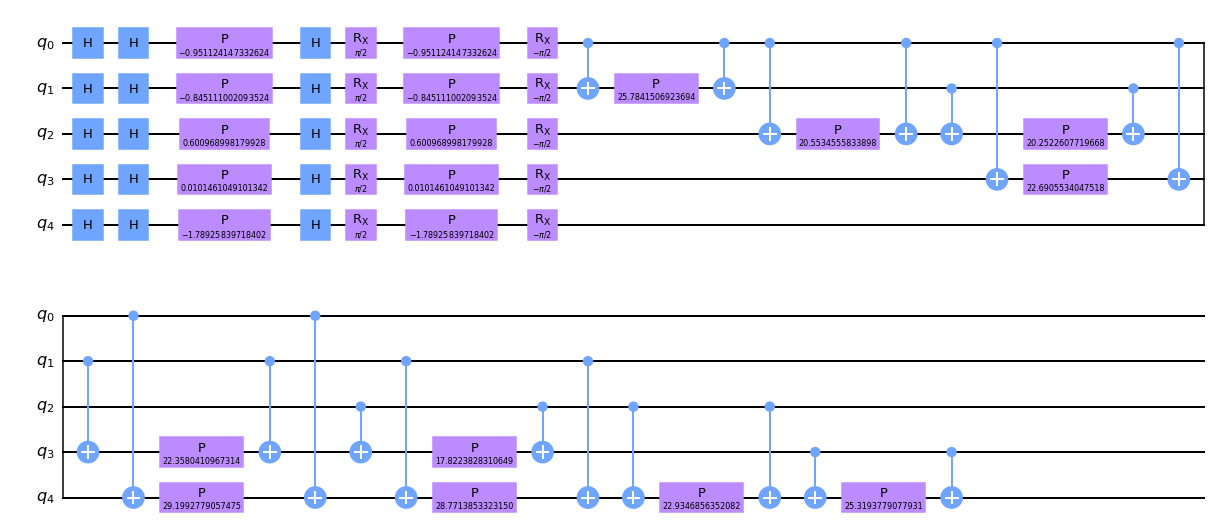

In [11]:
encode_map = PauliFeatureMap(feature_dimension=N_DIM, reps=1, paulis = ['X', 'Y', 'ZZ'])
encode_circuit = encode_map.bind_parameters(sample_train[0])
encode_circuit.decompose().draw(output='mpl')

In [12]:
ex3a_fmap = ZZFeatureMap(feature_dimension=5, reps=3, entanglement='circular')

### Quantum Kernel Estimation

In [15]:
pauli_map = PauliFeatureMap(feature_dimension=N_DIM, reps=1, paulis = ['X', 'Y', 'ZZ'])
pauli_kernel = QuantumKernel(feature_map=pauli_map, quantum_instance=Aer.get_backend('statevector_simulator'))

In [16]:
print(f'First training data : {sample_train[0]}')
print(f'Second training data: {sample_train[1]}')

First training data : [-0.47555946 -0.42254859  0.3002957   0.00523804 -0.89230796]
Second training data: [ 0.05258577 -0.67206553 -0.28162723  0.02263191 -0.38929994]


First we create and draw the circuit:

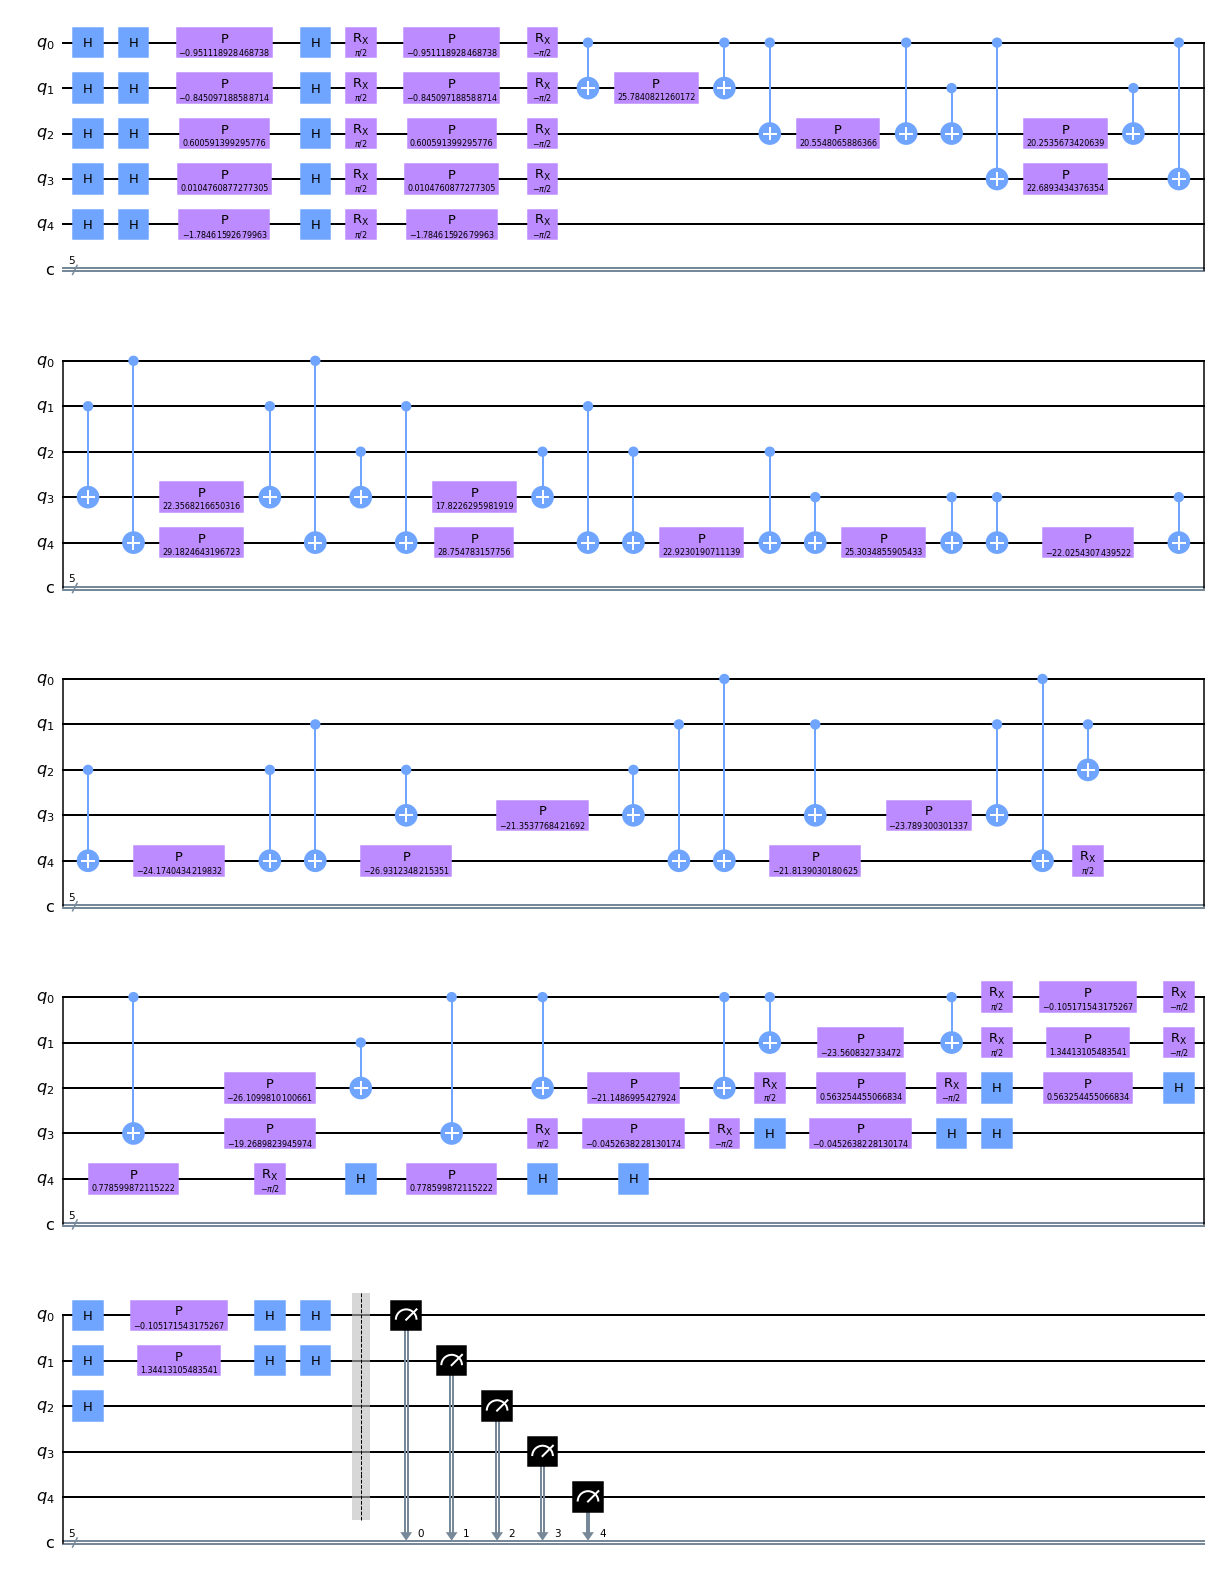

In [17]:
pauli_circuit = pauli_kernel.construct_circuit(sample_train[0], sample_train[1])
pauli_circuit.decompose().decompose().draw(output='mpl')

In [18]:
backend = Aer.get_backend('qasm_simulator')
job = execute(pauli_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(pauli_circuit)

In [19]:
print(f"Transition amplitude: {counts['0'*N_DIM]/sum(counts.values())}")

Transition amplitude: 0.03076171875


Here we compute and plot the training and testing kernel matrices:

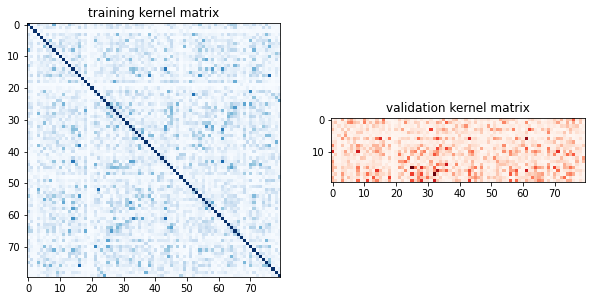

In [20]:
matrix_train = pauli_kernel.evaluate(x_vec=sample_train)
matrix_val = pauli_kernel.evaluate(x_vec=sample_val, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_val),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("validation kernel matrix")
plt.show()

### Quantum Support Vector Machine (QSVM)

In [22]:
pauli_svc = SVC(kernel='precomputed')
pauli_svc.fit(matrix_train, labels_train)
pauli_score = pauli_svc.score(matrix_val, labels_val)

print(f'Precomputed kernel classification test score: {pauli_score*100}%')

Precomputed kernel classification test score: 70.0%
